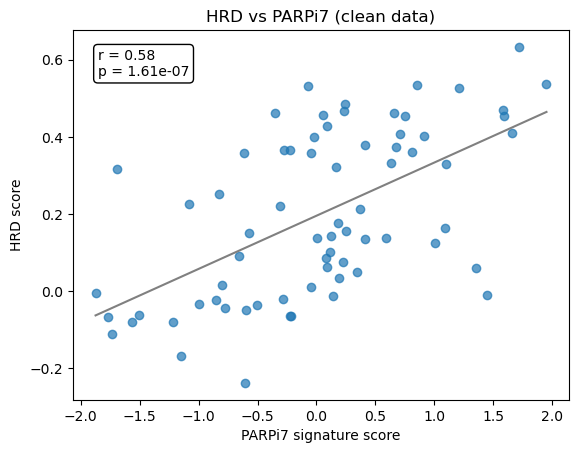

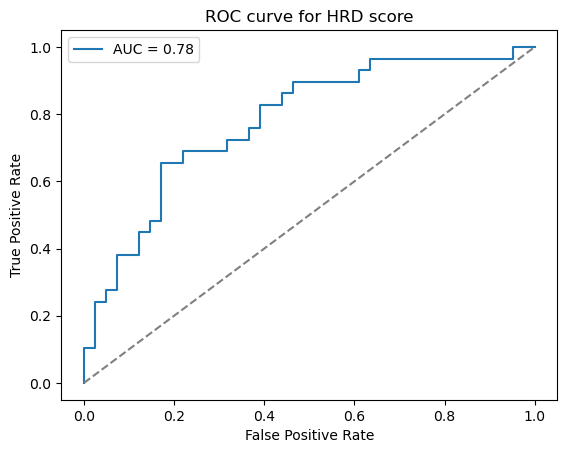

Mann–Whitney U p‐value = 7.55e-05
Cohen’s d = 1.11


In [14]:
from scipy.stats import pearsonr, mannwhitneyu
from sklearn.metrics import roc_auc_score, roc_curve

# …after you’ve built hrd_df…
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, mannwhitneyu
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Reload and process the data
expr = pd.read_csv(
    './validation/GSE173839_ISPY2_AgilentGeneExp_durvaPlusCtr_FFPE_meanCol_geneLevel_n105.txt',
    sep='\t', index_col=0
)
resp = pd.read_csv('./validation/GSE173839_ISPY2_DurvalumabOlaparibArm_biomarkers.csv')
resp = resp[resp['Arm'] == 'durvalumab/olaparib'].copy()
resp.loc[resp['pCR.status'] == -1, 'pCR.status'] = 0
resp['ResearchID'] = resp['ResearchID'].astype(str)

centroids = pd.read_csv('MultiScale_centroids.csv', index_col=0, skiprows=1)
# adjust these names if necessary after inspection
sig = centroids[['HRD', 'HR_proficient']]

genes = sig.index.intersection(expr.index)
samples = expr.columns.intersection(resp['ResearchID'])
expr_sub = expr.loc[genes, samples]
sig_sub  = sig.loc[genes, :]

# Compute HRD scores
hrd_scores = {}
for samp in samples:
    x = expr_sub[samp].values
    r_hrd = pearsonr(x, sig_sub['HRD'].values)[0]
    r_hrp = pearsonr(x, sig_sub['HR_proficient'].values)[0]
    hrd_scores[samp] = r_hrd - r_hrp

hrd_df = pd.DataFrame.from_dict(hrd_scores, orient='index', columns=['HRD_score']).reset_index().rename(columns={'index':'ResearchID'})
hrd_df = hrd_df.merge(resp[['ResearchID','pCR.status','PARPi7_sig.']], on='ResearchID')
hrd_df['Response'] = hrd_df['pCR.status'].map({0:'Non‑responder', 1:'Responder'})

# ——————————————————————————————————————
# Filter out any rows with missing HRD_score or pCR.status
hrd_clean = hrd_df.dropna(subset=['HRD_score','pCR.status','PARPi7_sig.'])

# 9. Recompute trend‐line stats on the clean subset
x = hrd_clean['PARPi7_sig.']
y = hrd_clean['HRD_score']
r, p_val = pearsonr(x, y)
m, b = np.polyfit(x, y, 1)
plt.figure()
plt.scatter(x, y, alpha=0.7)
xx = np.linspace(x.min(), x.max(), 100)
plt.plot(xx, m*xx + b, color='gray')
plt.annotate(
    f'r = {r:.2f}\np = {p_val:.2e}',
    xy=(0.05, 0.95), xycoords='axes fraction',
    va='top', ha='left',
    bbox=dict(boxstyle="round,pad=0.3", fc="white")
)
plt.xlabel('PARPi7 signature score')
plt.ylabel('HRD score')
plt.title('HRD vs PARPi7 (clean data)')
plt.show()

# 10. ROC curve + AUC
y_true  = hrd_clean['pCR.status']
scores  = hrd_clean['HRD_score']
auc      = roc_auc_score(y_true, scores)
fpr, tpr, _ = roc_curve(y_true, scores)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for HRD score')
plt.legend()
plt.show()

# 11. Mann–Whitney U and Cohen’s d
g0 = hrd_clean.loc[hrd_clean['pCR.status']==0, 'HRD_score']
g1 = hrd_clean.loc[hrd_clean['pCR.status']==1, 'HRD_score']
u_stat, p_mw = mannwhitneyu(g0, g1, alternative='two-sided')
pooled_sd = np.sqrt((g0.std()**2 + g1.std()**2)/2)
cohens_d  = (g1.mean() - g0.mean()) / pooled_sd

print(f"Mann–Whitney U p‐value = {p_mw:.2e}")
print(f"Cohen’s d = {cohens_d:.2f}")


/var/folders/w3/g9wcmyq92ljgw5bptd2_796c0000gn/T/ipykernel_81337/3709004264.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot,


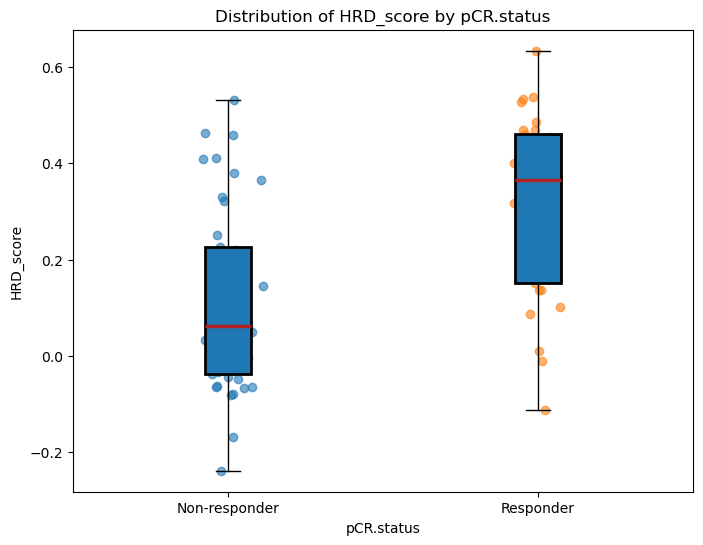

Welch's t‑test: t = -4.5671, p = 0.0000
Mann–Whitney U test: U = 262.0000, p = 0.0001


In [15]:
# 12. Boxplot of HRD_score by pCR.status + scatter + stats
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

# use your cleaned DataFrame
df = hrd_clean  # rename if yours is different

# define groups
labels = ['Non‑responder', 'Responder']
groups = [0, 1]
data_to_plot = [df.loc[df['pCR.status'] == g, 'HRD_score'] for g in groups]

# boxplot
plt.figure(figsize=(8,6))
boxprops   = dict(linestyle='-', linewidth=2, color='black')
medianprops= dict(linestyle='-', linewidth=2.5, color='firebrick')
plt.boxplot(data_to_plot,
            labels=labels,
            patch_artist=True,
            boxprops=boxprops,
            medianprops=medianprops)

# jittered scatter
for i, g in enumerate(groups):
    y = df.loc[df['pCR.status'] == g, 'HRD_score']
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.scatter(x, y, alpha=0.6)

plt.title('Distribution of HRD_score by pCR.status')
plt.xlabel('pCR.status')
plt.ylabel('HRD_score')
plt.show()

# 13. Statistical tests
g0 = df.loc[df['pCR.status'] == 0, 'HRD_score']
g1 = df.loc[df['pCR.status'] == 1, 'HRD_score']

t_stat, p_t = ttest_ind(g0, g1, equal_var=False)
u_stat, p_u = mannwhitneyu(g0, g1, alternative='two-sided')

print(f"Welch's t‑test: t = {t_stat:.4f}, p = {p_t:.4f}")
print(f"Mann–Whitney U test: U = {u_stat:.4f}, p = {p_u:.4f}")


In [ ]:
f1
mathews
confusion matrix
ccle
per-subtype

In [12]:


# -------------------- Data Loading and Preprocessing --------------------

# Load metadata and HRD scores
data_dir = "./data/"
ann_tcga = pd.read_csv(f"{data_dir}toga.breast.brca.status.txt", sep='\t', index_col=0)
hrd_scores = pd.read_excel(f"{data_dir}tcga.hrdscore.xlsx", index_col=0)

# Load RNAseq data
fpkm = pd.read_csv(f"{data_dir}tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt", sep='\t', index_col=0)

# Filter metadata
metadata = ann_tcga[~ann_tcga['event.RAD51C'].ne('0')]
metadata = metadata[~metadata['event.PALB2'].ne('0')]
metadata = metadata[metadata['event.BRCA1'] != '1']
metadata.index = metadata.index.str.replace('.', '-', regex=False)
hrd_scores.index = hrd_scores.index.map(lambda x: x[:12])
metadata = metadata.merge(hrd_scores[['HRD-sum']], left_index=True, right_index=True, how='inner')

# Process fpkm data
fpkm = fpkm.set_index('Case ID')
fpkm = fpkm[fpkm['Sample Type'] == 'Primary Tumor']
fpkm = fpkm.drop(columns=["Sample ID","Sample Type"])

filtered_columns = [col for col in fpkm.columns if '|' in col and 'protein_coding' in col.split('|')[2]]
fpkm = fpkm[filtered_columns]

# Further processing for fpkm
fpkm.columns = [col.split('|')[1] if '|' in col else col for col in fpkm.columns]
fpkm.index = fpkm.index.map(lambda x: x[:12])
fpkm = fpkm.loc[fpkm.index.intersection(metadata.index)]
fpkm.sort_index(inplace=True)
fpkm = fpkm.rename_axis("fpkm", axis="index")
fpkm = fpkm.apply(pd.to_numeric, errors='coerce')
fpkm.fillna(0, inplace=True)



features_df = fpkm
metadata_truncated = metadata.loc[metadata.index.intersection(features_df.index)]
# Add a base HRD status (not used in the final regression but for DESeq2 design)
metadata_truncated['HRD_status_base'] = metadata_truncated['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR')
metadata_truncated = metadata_truncated.sort_index()

features_df = features_df.fillna(0).astype(int)
features_df = features_df[sorted(features_df.columns)]

In [10]:
features_df = np.log2(features_df + 1)

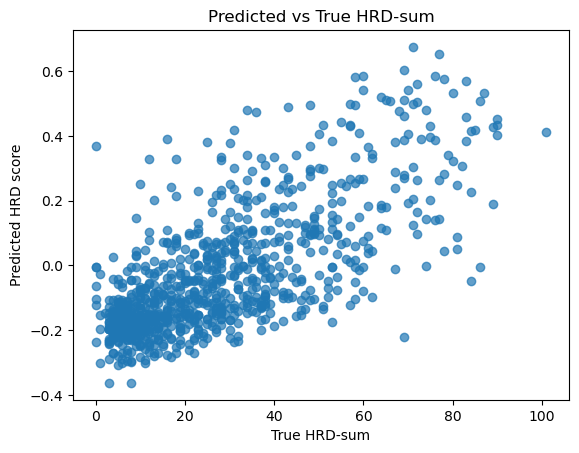

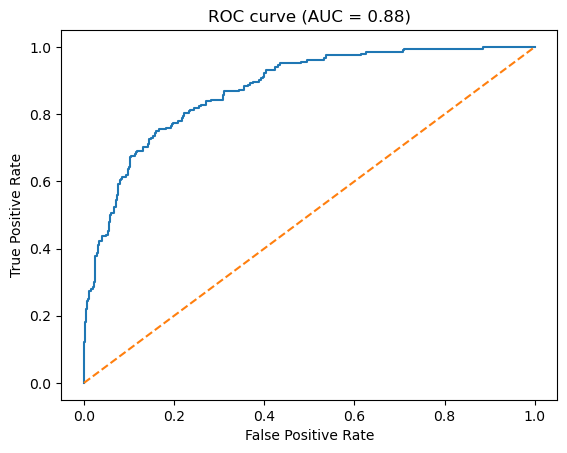

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Load centroids (adjust path as needed)
centroids = pd.read_csv('MultiScale_centroids.csv', index_col=0, skiprows=1)
# Identify the two template columns
hrd_col  = next(c for c in centroids.columns if 'hrd' in c.lower())
hrp_col  = next(c for c in centroids.columns if 'proficient' in c.lower())
sig = centroids[[hrd_col, hrp_col]]
sig.columns = ['HRD', 'HR_proficient']

# 2. Subset to common genes
genes = sig.index.intersection(features_df.columns)
sig_sub = sig.loc[genes]
expr_sub = features_df[genes]

# 3. Compute prediction scores per sample
pred_scores = {}
for sample in expr_sub.index:
    x = expr_sub.loc[sample].values
    r_hrd = pearsonr(x, sig_sub['HRD'].values)[0]
    r_hrp = pearsonr(x, sig_sub['HR_proficient'].values)[0]
    pred_scores[sample] = r_hrd - r_hrp

pred_df = pd.DataFrame.from_dict(pred_scores, orient='index', columns=['pred_score'])
pred_df.index.name = 'CaseID'

# 4. Merge with ground truth
pred_df = pred_df.merge(
    metadata_truncated[['HRD-sum','HRD_status_base']],
    left_index=True, right_index=True
)

# 5. Scatter: predicted score vs HRD-sum
plt.figure()
plt.scatter(pred_df['HRD-sum'], pred_df['pred_score'], alpha=0.7)
plt.xlabel('True HRD-sum')
plt.ylabel('Predicted HRD score')
plt.title('Predicted vs True HRD-sum')
plt.show()

# 6. ROC curve at threshold 42 for binary label
y_true  = (pred_df['HRD-sum'] >= 42).astype(int)
y_score = pred_df['pred_score']
auc      = roc_auc_score(y_true, y_score)
fpr, tpr, _ = roc_curve(y_true, y_score)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (AUC = {auc:.2f})')
plt.show()


In [17]:
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix, roc_auc_score

# 1. (Re‑)merge the PAM50 labels
pred_df = pred_df.merge(
    metadata_truncated[['event.PAM50']],
    left_index=True, right_index=True
)

# 2. Binarize ground truth & predictions
threshold = 0  # adjust if you want a different score cutoff
pred_df['true_label'] = (pred_df['HRD-sum'] >= 42).astype(int)
pred_df['pred_label'] = (pred_df['pred_score'] >= threshold).astype(int)

# 3. Overall metrics
f1  = f1_score(pred_df['true_label'], pred_df['pred_label'])
mcc = matthews_corrcoef(pred_df['true_label'], pred_df['pred_label'])
cm  = confusion_matrix(pred_df['true_label'], pred_df['pred_label'])

print("Overall performance:")
print(f"  F1 score           = {f1:.2f}")
print(f"  Matthews’ corrcoef = {mcc:.2f}")
print("  Confusion matrix:")
print(cm)

# 4. Per‑subtype F1 & AUC
print("\nPerformance by PAM50 subtype:")
for subtype, grp in pred_df.groupby('event.PAM50'):
    y_true  = grp['true_label']
    y_pred  = grp['pred_label']
    y_score = grp['pred_score']

    # skip if only one class present
    if len(np.unique(y_true)) < 2:
        print(f"  {subtype}: only one class present, skipping.")
        continue

    f1_sub  = f1_score(y_true, y_pred)
    auc_sub = roc_auc_score(y_true, y_score)
    print(f"  {subtype:<6}  F1 = {f1_sub:.2f},  AUC = {auc_sub:.2f}")


Overall performance:
  F1 score           = 0.63
  Matthews’ corrcoef = 0.50
  Confusion matrix:
[[541 142]
 [ 46 158]]

Performance by PAM50 subtype:
  Basal   F1 = 0.76,  AUC = 0.72
  Her2    F1 = 0.49,  AUC = 0.70
  LumA    F1 = 0.42,  AUC = 0.87
  LumB    F1 = 0.57,  AUC = 0.78


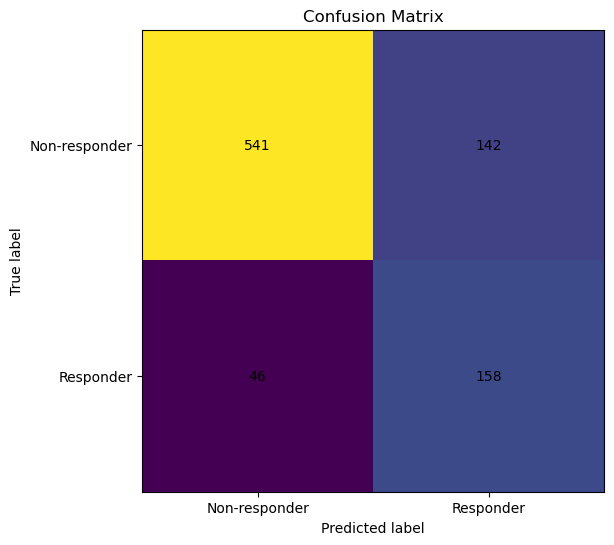

In [20]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt

# Manual confusion matrix calculation to avoid heavy numpy threading
true_labels = pred_df['true_label'].tolist()
pred_labels = pred_df['pred_label'].tolist()
labels = ['Non-responder', 'Responder']

cm = [[0, 0], [0, 0]]
for t, p in zip(true_labels, pred_labels):
    cm[t][p] += 1

# Plot as heatmap
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm)

# Annotate counts
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i][j], ha='center', va='center')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
plt.show()


In [22]:
data_dir = "./data"
genes_validation = pd.read_csv(f'{data_dir}/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

#genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)

breast_filt = genes_validation_transposed[genes_validation_transposed.index.str.contains('BREAST')]
breast_filt = breast_filt.set_index(breast_filt.index.str.split('_').str[0])
breast_filt.head()

prism = pd.read_excel(f'{data_dir}/validation/PRISM_CCLE.xlsx', skiprows=1)
prism['CellLine'] = prism['CellLine'].replace('-', '', regex=True)

samp_prism = set(list(prism['CellLine']))
samp_val_genes = set(list(breast_filt.index))



OLAPARIB: Welch t = nan (p=nan),  MW U = 20.00 (p=4.62e-01)


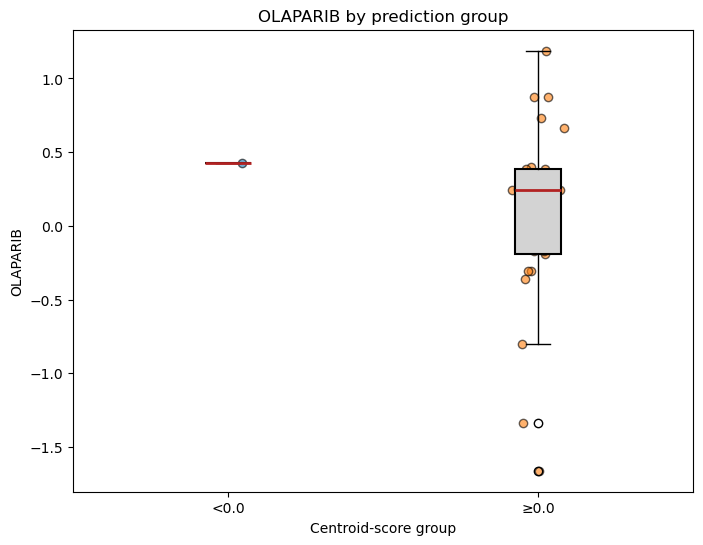


TALAZOPARIB: Welch t = nan (p=nan),  MW U = 21.00 (p=3.85e-01)


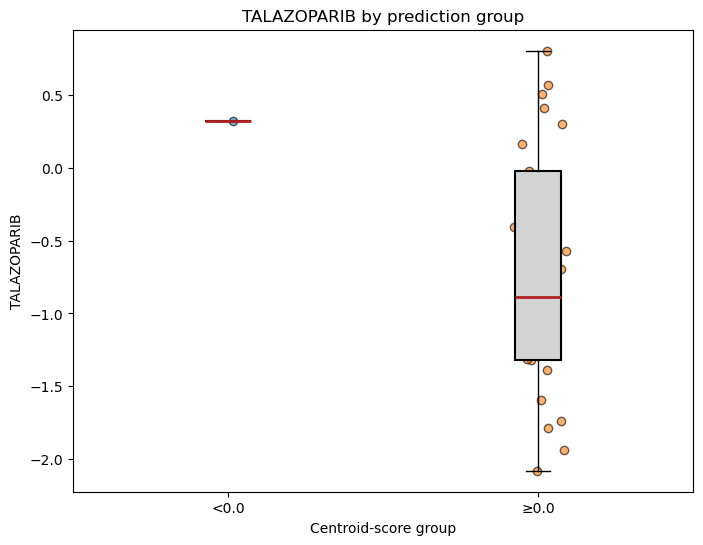


NIRAPARIB: Welch t = nan (p=nan),  MW U = 21.00 (p=3.85e-01)


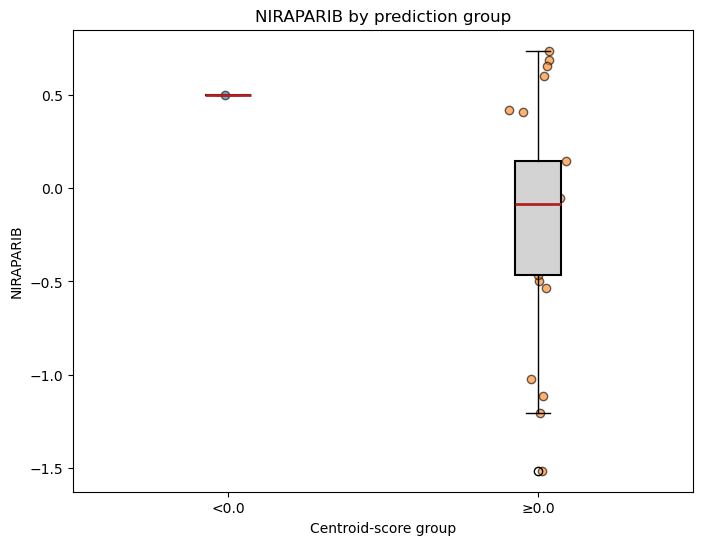


RUCAPARIB: Welch t = nan (p=nan),  MW U = 2.00 (p=2.40e-01)


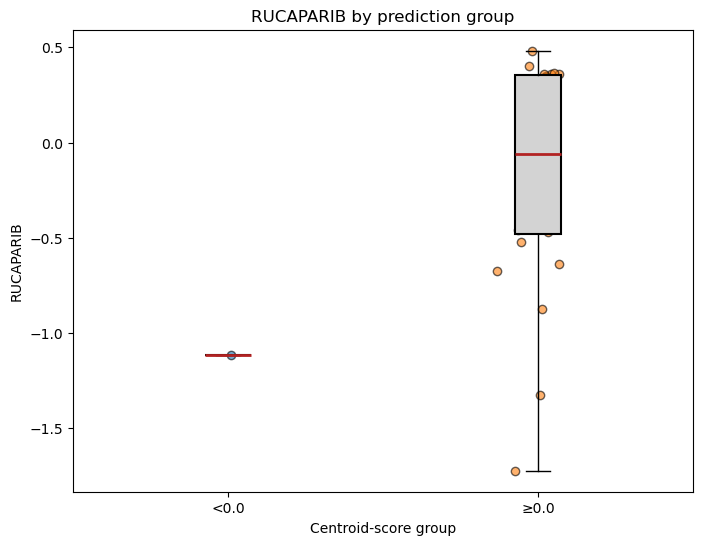

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt

# --- 1. load & prep centroids ---
centroids = pd.read_csv('MultiScale_centroids.csv', index_col=0, skiprows=1)
hrd_col = next(c for c in centroids.columns if 'hrd' in c.lower())
hrp_col = next(c for c in centroids.columns if 'proficient' in c.lower())
sig = centroids[[hrd_col, hrp_col]].rename(columns={hrd_col:'HRD', hrp_col:'HR_proficient'})

# --- 2. intersect genes & compute scores ---
common = sig.index.intersection(breast_filt.columns)
expr_sub = breast_filt[common]           # samples × genes
sig_sub  = sig.loc[common]               # genes × {HRD,HR_proficient}

scores = {}
for cl in expr_sub.index:
    x = expr_sub.loc[cl].values
    r_h = pearsonr(x, sig_sub['HRD'].values)[0]
    r_p = pearsonr(x, sig_sub['HR_proficient'].values)[0]
    scores[cl] = r_h - r_p

pred_df = pd.DataFrame.from_dict(scores, orient='index', columns=['pred_score'])
pred_df.index.name = 'CellLine'

# --- 3. merge into prism & choose threshold ---
prism2 = prism.set_index('CellLine').join(pred_df, how='inner').reset_index()
thr = 0.0    # you can tweak this

# --- 4. loop through PRISM cols 3–6, stats + plots ---
for col in prism2.columns[3:7]:
    g0 = prism2.loc[prism2['pred_score'] < thr, col].dropna()
    g1 = prism2.loc[prism2['pred_score'] >= thr, col].dropna()

    t, p_t = ttest_ind(g0, g1, equal_var=False)
    u, p_u = mannwhitneyu(g0, g1, alternative='two-sided')
    print(f"\n{col}: Welch t = {t:.2f} (p={p_t:.2e}),  MW U = {u:.2f} (p={p_u:.2e})")

    fig, ax = plt.subplots(figsize=(8,6))
    bp = ax.boxplot([g0, g1],
                    positions=[0,1],
                    patch_artist=True,
                    boxprops=dict(facecolor='lightgray', linewidth=1.5),
                    medianprops=dict(color='firebrick', linewidth=2))
    # scatter
    x0 = np.random.normal(0, 0.04, size=len(g0))
    x1 = np.random.normal(1, 0.04, size=len(g1))
    ax.scatter(x0, g0, alpha=0.6, edgecolor='k')
    ax.scatter(x1, g1, alpha=0.6, edgecolor='k')

    ax.set_xticks([0,1])
    ax.set_xticklabels([f"<{thr}", f"≥{thr}"])
    ax.set_xlabel('Centroid‑score group')
    ax.set_ylabel(col)
    ax.set_title(f"{col} by prediction group")
    plt.show()
